In [1]:
from decimal import Decimal
import numpy as np 
from cadCAD.configuration import Experiment
from typing import Dict, List, Tuple
from dataclasses import dataclass
from cadCAD.configuration.utils import env_trigger, bound_norm_random, ep_time_step, config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext,Executor
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import string
import random
from dataclasses import asdict

In [2]:
import sys
sys.path.append("../")
from utils.plot_utils import plot_results
from utils.data_format_utils import prep_results

In [3]:
from model.policy import lend_policy
from model.state_update import su_btc_pool,su_lend_module, su_rune_supply_tracker, su_thor_usd_pool,su_thor_usd_vault

In [4]:
from model.model_data_classes import pool, RuneSupply, ThorUsdVault, SavingsVault, ThorUsdVault, Thorchad, LpPosition

# Basic Savings

**Savings - Blue Chip**
![title](images/blue-chip-savings.png)

In [5]:
# Pool Amplification Factor to tweak mint/redeem fees (down to force higher fees)
POOL_AMP_FACTOR = 0.999
# Saver Block Reward Frequency to tweak USD Saver yield (down to force higher yield)
SAVE_BLOCK_REWARD = 0.0
# Saver Deposit Time Minimum to tweak attracting mercenary capital (down to get more capital)
SAVE_DEPOSIT_MIN_BLOCKS = 0 # blocks
# Loan Deposit Time Minimum to tweak attracting mercenary lenders (down to get more lenders)
LOAN_DEPOSIT_MIN_BLOCKS = 0 # blocks
# Maximum CR users are willing take loan for.
MAX_DESIREABLE_CR = 2.5 # 2.5 = 250%
# Loan MaxCR to tweak attracting all lenders (down to get more lenders)
MAX_CR = 3.0 # in percent, 3 = 300%
MIN_CR = 1.0

MIN_DESIREABLE_SAVINGS_APY = 3.0 # 3 percent
#RUNE_PRICE_USD = 10.0

## Initial State

In [6]:
# btc LP pool values
btc_pool = pool(pool_asset_depth=875.0,
                pool_rune_depth=5000000,
                pool_asset_collateral = 175.0, 
                pool_rune_collateral=1000000,
                pool_yield=20.0, # percent
                asset_price_usd=40000.0,
                pool_units=500246145359196,
                historic_slip=[0.0]
               )


# thor.usd virtual pool values
thor_usd_pool = pool(pool_asset_depth=70000000, # THOR.USD in THOR.USD/RUNE pool
                pool_rune_depth=10000000, # RUNE in THOR.USD/RUNE pool
                pool_asset_collateral =0.0, 
                pool_rune_collateral=0.0,
                pool_yield=20.0, # percent
                asset_price_usd=7.0,
                pool_units= 0,
                historic_slip=[0.0]
               )

# Amount of rune in the system
rune_supply_tracker = RuneSupply(
                        rune_supply=500_000_000,
                        rune_lend_inflation=0,
                        rune_save_deflation=0 
                    )

btc_vault = SavingsVault(
            asset='THOR.BTC',
            deposits=0.0,
            withdrawals=0.0,
            APY=10, # 10%
            members = {}  # user key, initial deposit value
            )


# vault balances
usd_vault = ThorUsdVault(
             fee_revenue=0.,
                deposits=0.,
                withdrawals=0.,
                APY=10,
                #members = {}
             )

# Single user 
btc_lper = Thorchad(
            pool="BTC.BTC",
            lp_asset_amount=0.0, # portion of Lp in asset term
            lp_rune_amount=0.0, # portion of lp in rune term
            debt_owed=0.0, # in thor.usd terms
            debt_received=0.0,
            CR=0.0,
            savings_asset='',
            savings_deposit=0.0,
            asset_wallet='BTC.BTC',
            asset_wallet_balance=1.0,
            savings_deposit_block=0
            

) # in thor.usd terms)



INITIAL_STATE_DICT = {
    'btc_pool' : btc_pool, # state of the pool
    'thor_btc_vault': btc_vault,
    'thor_usd_pool' : thor_usd_pool,
    'rune_supply_tracker': rune_supply_tracker,#
    'thor_usd_vault': usd_vault,
    'users':{'user1': btc_lper}
    
}

## Helpers

In [7]:
def generate_random_user_id():
    rand_3= random.choices(string.ascii_uppercase, k=3)
    user_id = "".join(rand_3)
    
    return user_id

In [8]:
def calc_asset_emission(
    x_input_amount: float, 
    X_virtual_input_side: float,
    Y_virtual_output_side:float, 
    ):
    '''
    mint / redeem
    same as `_calc_asset_emission()`
    Source: https://gitlab.com/thorchain/heimdall/-/blob/develop/thorchain/thorchain.py#L1491
    
    y = (x * X * Y) / (x + X) ** 2
    
    ''' 
    y_output_amount = (x_input_amount * X_virtual_input_side * Y_virtual_output_side) / (x_input_amount + X_virtual_input_side) ** 2
    
    return y_output_amount

In [9]:
def calc_liq_fee(x_input_amount: float, X_input_side: float, Y_output_side:float):
    
    """
    f: fee collected
    x: input amount (RUNE or USD)
    X: input side/depth (RUNE or USD)
    Y: output side/depth (RUNE or USD)

    f = (x * x * Y)/(x + X)^2 
    """
    
    fee = (x_input_amount * x_input_amount * Y_output_side) / ( x_input_amount + X_input_side) ** 2
    
    return fee

In [10]:
# TODO - add calc_swap_slip() - append swap slip to each virtual pool, slip amount
# grab last 300 and sum them - then we have virtual pool depth increase,
# and then that can throttle the pool depth.

def calc_swap_slip(X_asset_depth: float, x_input_amount: float):
        """
        Calculate the trade slip from a trade
        expressed as a percentage. 0.1 = 10%
        x / (X + x)

        :param int X_asset_depth: first balance, depth of pool
        :param int x_input_amount: asset amount
        :returns: float trade slip

        """
        swap_slip = x_input_amount / (X_asset_depth + x_input_amount)
        return round(swap_slip, 5) #int(round(swap_slip))



In [19]:
LpPosition?

## Policy

In [35]:
def save_policy(_params, substep, state_history, previous_state):
        
     
    # Check that the previous state vault apy is not less than the min desireable apy
    if previous_state['thor_btc_vault'].APY < _params['min_desireable_apy']:

        # since no loans only passing previous CR to next block.
        return {
            "update_vault_apy": previous_state['thor_btc_vault'].APY
        }
    
    current_block = previous_state["timestep"]
    
    # not sure how to iterate users
    #user = previous_state['saver']['user1']
    saver = _params['saver'][current_block]
    # Pretending `lp_asset_amount` is a wallet balance, BTC in this case
    saver_wallet_balance = saver.lp_asset_amount 
    btc_pool = previous_state['btc_pool']
    btc_vault = previous_state['thor_btc_vault']
    thor_usd_pool = previous_state['thor_usd_pool']
    usd_vault = previous_state['thor_usd_vault']
    
    # 1. SWAP asset to RUNE
    rune_amount = calc_asset_emission(
            x_input_amount=saver_wallet_balance,
            X_virtual_input_side=btc_pool.pool_asset_depth,
            Y_virtual_output_side=btc_pool.pool_rune_depth, 
        )
    
    # 2.  Calculate slip from swap, appended to 
    # swap slip is appended to list in each virtual pool
    # grab last 300 slip values and use to throttle the pool depth defensively.
    slip_pct = calc_swap_slip(
        X_asset_depth=btc_pool.pool_asset_depth,
        x_input_amount=saver_wallet_balance
    ) # percent, 0.01 = 1%
    
    # 3. BURN (swap) rune for thor.btc (mint)
    thor_btc_amount = calc_asset_emission(
            x_input_amount=rune_amount, 
            X_virtual_input_side=btc_pool.pool_rune_depth,
            Y_virtual_output_side=btc_pool.pool_asset_depth, 
        )
    
    # 4. Calc thor.btc mint fee
    mint_fee_thor_btc = calc_liq_fee(
                    x_input_amount=rune_amount,
                    X_input_side=btc_pool.pool_rune_depth, 
                    Y_output_side=btc_pool.pool_asset_depth, 
                ) # output in thor.btc terms.
    
    # 5. Convert mint fee value to rune
    # get asset anchor price in RUNE
    anchor_price_rune = btc_pool.pool_rune_depth / btc_pool.pool_asset_depth
    
    mint_fee_rune = anchor_price_rune * mint_fee_thor_btc
    
    # convert fee rune to thor.usd
    usd_per_rune = thor_usd_pool.pool_asset_depth / thor_usd_pool.pool_rune_depth
    # send mint fees to thor.usd vault in state-update fn
    mint_fee_usd = mint_fee_rune * usd_per_rune

    # 6. Get amount of rune burned to mint the thor.btc
    burned_rune_amt = anchor_price_rune * thor_btc_amount
    
    # generate a random user id
    fake_user_id = generate_random_user_id()
    
    savings_member_entry = {
                    'user': fake_user_id,
                    'derived_asset_amount': thor_btc_amount,
                    'block': current_block
                          }
    
    policy_update_values = {
                            'update_usd_vault_fee_revenue': mint_fee_usd,
                            'update_slip_pct': slip_pct,
                            'update_user_thor_btc': thor_btc_amount,
                            'update_savings_deposit_amt': thor_btc_amount,
                            'update_rune_save_deflation': burned_rune_amt,
                            'update_savings_member': savings_member_entry,
                            }
    
    return (policy_update_values)


def withdraw_save_policy(_params, substep, state_history, previous_state):
    
    # TODO 
    
#     policy_update_values = {
#                             'update_x': 1, 
#                             'update_y':2
#                            }
    
    #return (policy_update_values)
    
    pass



def vault_yield_policy(_params, substep, state_history, previous_state):

    # takes the state of the thor.asset vault, asset pool and calcualtes 
    # the yield for each member (pro rata share)
    
    pass
    

## State update Function

In [44]:
def su_thor_btc_vault(params, step, sL, s, _input) -> Tuple:
    
    
    """
    Update Thor.btc vault
    """
    
    new_state = s.copy()
    btc_vault = new_state['thor_btc_vault']
    
    input_keys = list(_input.keys())
    
    if 'update_savings_deposit_amt' in input_keys:
        btc_vault.deposits += _input['update_savings_deposit_amt']
    
    # reduce values if there is a withdrawal
    if 'update_savings_withdrawal_amt' in input_keys:
        btc_vault.deposits -= _input['update_savings_withdrawal_amt']
        btc_vault.withdrawals += _input['update_savings_withdrawal_amt']
    
    if 'update_savings_member' in input_keys:
        
        btc_vault.members.update(_input['update_savings_member'])
        
    # TODO - update the vault APY based on the Collateral...
        
    return ('thor_btc_vault', btc_vault)

def su_thor_usd_vault(params, step, sL, s, _input) -> Tuple:
    
    """
    state update for usd_vault
    """
    
    new_state = s.copy()
    thor_usd_vault = new_state['thor_usd_vault']
    
    # update vault fee revenue
    thor_usd_vault.fee_revenue += _input['update_usd_vault_fee_revenue']
    
    # TODO - extend for other _input keys
    # example a thor_usd_vault_deposit or withdrawal etc.
    
    return ('thor_usd_vault', thor_usd_vault)


def su_rune_supply_tracker(params, step, sL, s, _input) -> Tuple:
    """
    state update for rune supply tracker
    """
    new_state = s.copy()
    rune_supply_tracker = new_state['rune_supply_tracker']
    
    input_keys = list(_input.keys())
    
    if 'update_rune_lend_inflation' in input_keys:
        
        # TODO - make update_rune_lend_inflation consistent with save_deflation
        # DONT update values in policy
        rune_supply_tracker.rune_lend_inflation = _input['update_rune_lend_inflation']
        rune_supply_tracker.rune_supply = rune_supply_tracker.rune_supply + _input['update_rune_lend_inflation']

    # if policy_input['update_rune_save_deflation']       
    if 'update_rune_save_deflation' in input_keys:
        rune_supply_tracker.rune_save_deflation += _input['update_rune_save_deflation']
        rune_supply_tracker.rune_supply = rune_supply_tracker.rune_supply - _input['update_rune_save_deflation']
    
    return ('rune_supply_tracker', rune_supply_tracker)


def su_btc_pool(params, step, sL, s, _input) -> Tuple:
    
    """
    state update for btc pool
    """
    
    new_state = s.copy()
    btc_pool = new_state['btc_pool']
    
    input_keys = list(_input.keys())
    
    if 'update_pool_rune_collateral' in input_keys:
        btc_pool.pool_rune_collateral = _input['update_pool_rune_collateral']
        btc_pool.pool_asset_collateral = _input['update_pool_asset_collateral']
    
    if 'update_slip_pct' in input_keys:
        # Track slip pct to trigger defense.
        # TODO - make this generic for any virtual pool? Prob should have virt pool for btc too.
        #hist_slip = btc_pool.historic_slip
        
        #import pdb; pdb.set_trace()
        
        hist_slip = btc_pool.historic_slip
        hist_slip.append(_input['update_slip_pct'])
        
        # update
        btc_pool.historic_slip = hist_slip
    
    return ('btc_pool', btc_pool)


## Config Partial State update Block

In [45]:
partial_state_update_blocks = [
    {
        'policies': {
            'save_policy': save_policy
        },
        # keys for State Update funcs
        'variables': {
            
            'btc_pool': su_btc_pool,
            'thor_btc_vault': su_thor_btc_vault,
            'thor_usd_vault': su_thor_usd_vault,
            #'thor_usd_pool': su_thor_usd_pool,
            'rune_supply_tracker': su_rune_supply_tracker,
            #'users': su_users_savings,
        }
    }
]

## System Paramters

In [46]:
def _generate_saver_list(n: int = 100):
    
    '''    
    Generates a list of lp positions to pass to sys_params.
    Each of these lp positions will be used as a proxy for a savings user deposit,
    if the Savings Vault APY is considered desirable. 
    '''
    
    savers_list = []

    for i in range(n + 1):
        
        # Just an asset value
        saver = LpPosition(
                        pool='BTC.BTC',
                        lp_asset_amount=0.175,
                        lp_rune_amount=0,
                        lp_units=0,
                    )

        savers_list.append(saver)

    return savers_list

In [47]:
savers_list = _generate_saver_list(n=100)

In [48]:
sys_params = {
    'pool_amp_factor': [POOL_AMP_FACTOR],
    'max_CR': [MAX_CR],
    'min_cr': [MIN_CR], # Not currently used, hard coded at 1 (100%)
    'max_desirable_CR': [MAX_DESIREABLE_CR],
    'min_desireable_apy': [MIN_DESIREABLE_SAVINGS_APY],
    'saver': [savers_list]
    #'borrower': [borrower_list] # list of LP dataclass objects
}

In [49]:
sim_config = config_sim({
    'T': range(100), # number of discrete iterations in each experiment
    'N': 1, # number of times the simulation will be run (monte carlo runs)
    'M': sys_params # param sweep dict
})


# params - price series for btc, 

In [50]:
exp = Experiment()
exp.append_model(
    model_id = 'savings-thorfi', # OPTIONAL: System Model label
    initial_state = INITIAL_STATE_DICT, # System Model
    partial_state_update_blocks = partial_state_update_blocks, # System Model
    policy_ops =[save_policy], # System Model
    sim_configs = sim_config, # Simulation Properties
    # user_id = ..., # OPTIONAL: Configuration User ID
)

In [51]:
# Run sim
exec_mode = ExecutionMode()
local_proc_ctx = ExecutionContext(context=exec_mode.local_mode)
run = Executor(exec_context=local_proc_ctx, configs=exp.configs)

raw_result, tensor_field, sessions = run.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 6, 1, 6)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 6, 1, 6)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.03s


## Inspect Results 

In [93]:

def prep_results(raw_result: List, asset_pool_col: str, vault_name_col: str):
    def _create_pool_df(
        result_df: pd.DataFrame, asset_pool_col: str = "btc_pool"
    ) -> pd.DataFrame:

        pool_df = pd.DataFrame([asdict(x) for x in result[asset_pool_col].to_list()])
        pool_df["loan_collat_proportion"] = (
            pool_df["pool_rune_collateral"] / pool_df["pool_rune_depth"]
        )

        return pool_df

    def _create_loan_df(result_df: pd.DataFrame):
        all_loans = result["lend_module"].iloc[
            -1
        ]  # get last row of lend module, with full loan history.
        loan_df = pd.DataFrame(all_loans.loans).T.reset_index()
        loan_df = loan_df.rename(columns={"index": "loan_id"})

        return loan_df
    
    def _create_pool_df(
        result_df: pd.DataFrame, asset_pool_col: str = "btc_pool"
    ) -> pd.DataFrame:

        pool_df = pd.DataFrame([asdict(x) for x in result[asset_pool_col].to_list()])
        pool_df["loan_collat_proportion"] = (
            pool_df["pool_rune_collateral"] / pool_df["pool_rune_depth"]
        )

        return pool_df
    
    def _create_savings_vault_deposit_dfs(
        result_df: pd.DataFrame, vault_col_name: str = 'thor_btc_vault'
    ) -> pd.DataFrame:

        vault_df = pd.DataFrame([asdict(x) for x in result[vault_col_name].to_list()])
        
        deposits_df = pd.DataFrame([x for x in vault_df['members'].to_list()])
        
        return vault_df, deposits_df
    
    

    results_dict = {}
    
    result = pd.DataFrame(raw_result)
    
    results_dict.update({'result': result})
    
    if asset_pool_col in result.columns.to_list():
        
        pool_df = _create_pool_df(result_df=result, asset_pool_col=asset_pool_col)
        
        results_dict.update({'pool_df': pool_df})
    
    if "lend_module" in result.columns.to_list():
        
        loan_df = _create_loan_df(result_df=result)
        
        results_dict.update({'loan_df': loan_df})
        
        
    if vault_name_col in  result.columns.to_list():
        vault_df, deposits_df = _create_savings_vault_deposit_dfs(
                                     result_df=result,
                                     vault_col_name=vault_name_col
                                 )
        
        results_dict.update({'vault_df': vault_df})
        results_dict.update({'deposits_df': deposits_df})
    
    return results_dict


In [94]:
results_dict = prep_results(raw_result=raw_result, 
                            asset_pool_col='btc_pool',
                           vault_name_col='thor_btc_vault'
                           ) 

In [95]:
results_dict.keys()

dict_keys(['result', 'pool_df', 'vault_df', 'deposits_df'])

In [55]:
pool_df = results_list[1]

In [57]:
results_df['thor_btc_vault']

0      SavingsVault(asset='THOR.BTC', deposits=0.0, w...
1      SavingsVault(asset='THOR.BTC', deposits=0.1748...
2      SavingsVault(asset='THOR.BTC', deposits=0.3497...
3      SavingsVault(asset='THOR.BTC', deposits=0.5245...
4      SavingsVault(asset='THOR.BTC', deposits=0.6994...
                             ...                        
96     SavingsVault(asset='THOR.BTC', deposits=16.786...
97     SavingsVault(asset='THOR.BTC', deposits=16.961...
98     SavingsVault(asset='THOR.BTC', deposits=17.136...
99     SavingsVault(asset='THOR.BTC', deposits=17.311...
100    SavingsVault(asset='THOR.BTC', deposits=17.486...
Name: thor_btc_vault, Length: 101, dtype: object

In [58]:
def _create_savings_vault_df(
        result_df: pd.DataFrame, vault_col_name: str = 'thor_btc_vault'
    ) -> pd.DataFrame:

        vault_df = pd.DataFrame([asdict(x) for x in result[vault_col_name].to_list()])

        return vault_df

In [80]:
vault_df

asset   deposits  withdrawals  APY  \
0    THOR.BTC   0.000000          0.0   10   
1    THOR.BTC   0.174860          0.0   10   
2    THOR.BTC   0.349720          0.0   10   
3    THOR.BTC   0.524580          0.0   10   
4    THOR.BTC   0.699440          0.0   10   
..        ...        ...          ...  ...   
96   THOR.BTC  16.786569          0.0   10   
97   THOR.BTC  16.961429          0.0   10   
98   THOR.BTC  17.136290          0.0   10   
99   THOR.BTC  17.311150          0.0   10   
100  THOR.BTC  17.486010          0.0   10   

                                               members  
0                                                   {}  
1    {'user': 'CZW', 'derived_asset_amount': 0.1748...  
2    {'user': 'PRC', 'derived_asset_amount': 0.1748...  
3    {'user': 'EGB', 'derived_asset_amount': 0.1748...  
4    {'user': 'RES', 'derived_asset_amount': 0.1748...  
..                                                 ...  
96   {'user': 'ZXJ', 'derived_asset_amount': 0.1748...  
97   {'user': 'PLT', 'derived_asset_amount': 0.1748...  
98   {'user': 'SEV', 'derived_asset_amount': 0.1748...  
99   {'user': 'RBK', 'derived_asset_amount': 0.1748...  
100  {'user': 'PHO', 'derived_asset_amount': 0.1748...  

[101 rows x 5 columns]

In [60]:
vault_df = _create_savings_vault_df(results_df)

In [84]:
deposits_df 

user  derived_asset_amount  block
0    NaN                   NaN    NaN
1    CZW               0.17486    0.0
2    PRC               0.17486    1.0
3    EGB               0.17486    2.0
4    RES               0.17486    3.0
..   ...                   ...    ...
96   ZXJ               0.17486   95.0
97   PLT               0.17486   96.0
98   SEV               0.17486   97.0
99   RBK               0.17486   98.0
100  PHO               0.17486   99.0

[101 rows x 3 columns]

In [85]:
deposits_df = pd.DataFrame([x for x in vault_df['members'].to_list()])

<AxesSubplot:>

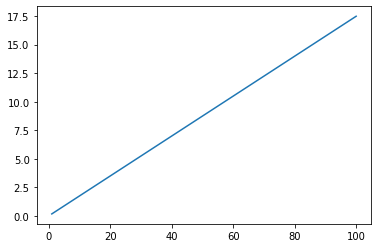

In [83]:
deposits_df['derived_asset_amount'].cumsum().plot()

In [79]:
deposits_df['derived_asset_amount'].cumsum() / deposits_df['block'].cumsum()

0          inf
1     0.349720
2     0.174860
3     0.116573
4     0.087430
        ...   
95    0.003681
96    0.003643
97    0.003605
98    0.003569
99    0.003533
Length: 100, dtype: float64

In [ ]:
deposits_df.gropupby('user')

In [75]:
#deposits_df.head(25)

In [71]:
# What proportion of the total deposits are redeamble at any given point in time?

In [ ]:
for each block that passes 1% of the intial amount is redeemable for no fee, any additional amount gets charged a fee.



In [73]:
for block in deposits_df['block']:
    print(block)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [27]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [29]:
plot_results(
    result_df=result,
    pool_df=pool_df,
    pool_name='BTC.BTC',
    loan_df=pd.DataFrame({}))

KeyError: 'lend_module'